
--- Performance Measures ---
Average Waiting Time: 0.07
Probability of Wait: 0.08
Probability of Idle Servers: 0.19
Average Service Time: 2.13
Average Time Between Arrivals: 3.99
Average System Time: 2.20


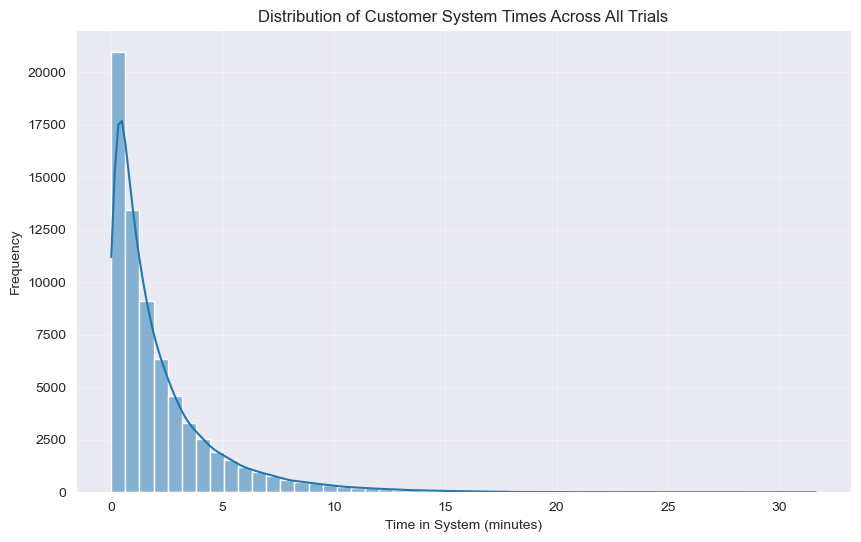

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def Double_Queue(n_customers, shift_time=9*60):
    mean_interarrival = 4.0
    mean_service_Able = 3.0
    mean_service_Baker = 0.9

    arrival_times = []
    service_times_Able = []
    service_times_Baker = []
    service_start_Able = []
    service_start_Baker = []
    service_end_Able = []
    service_end_Baker = []
    server_assigned = []
    waiting_times = []
    system_times = []

    interarrival_times = [random.expovariate(1.0 / mean_interarrival) for _ in range(n_customers)]
    service_times_Able = [random.expovariate(1.0 / mean_service_Able) for _ in range(n_customers)]
    service_times_Baker = [random.expovariate(1.0 / mean_service_Baker) for _ in range(n_customers)]

    arrival_times.append(shift_time + interarrival_times[0])
    service_start_Able.append(arrival_times[0])
    service_end_Able.append(service_start_Able[0] + service_times_Able[0])
    service_start_Baker.append(0)
    service_end_Baker.append(0)
    waiting_times.append(0)
    server_assigned.append('Able')
    system_times.append(service_times_Able[0])

    last_able_end = service_end_Able[0]
    last_baker_end = service_end_Baker[0]

    for i in range(1, n_customers):
        arrival_times.append(arrival_times[i-1] + interarrival_times[i])
        current_arrival = arrival_times[i]

        if current_arrival >= last_able_end:
            service_start_Able.append(current_arrival)
            service_end_Able.append(current_arrival + service_times_Able[i])
            last_able_end = current_arrival + service_times_Able[i]
            waiting_time = 0
            server_assigned.append('Able')
            service_time = service_times_Able[i]
            service_start_Baker.append(0)
            service_end_Baker.append(0)
        elif current_arrival >= last_baker_end:
            service_start_Baker.append(current_arrival)
            service_end_Baker.append(current_arrival + service_times_Baker[i])
            last_baker_end = current_arrival + service_times_Baker[i]
            waiting_time = 0
            server_assigned.append('Baker')
            service_time = service_times_Baker[i]
            service_start_Able.append(0)
            service_end_Able.append(0)
        else:
            if last_able_end <= last_baker_end:
                service_start_Able.append(last_able_end)
                service_end_Able.append(last_able_end + service_times_Able[i])
                waiting_time = last_able_end - current_arrival
                last_able_end += service_times_Able[i]
                server_assigned.append('Able')
                service_time = service_times_Able[i]
                service_start_Baker.append(0)
                service_end_Baker.append(0)
            else:
                service_start_Baker.append(last_baker_end)
                service_end_Baker.append(last_baker_end + service_times_Baker[i])
                waiting_time = last_baker_end - current_arrival
                last_baker_end += service_times_Baker[i]
                server_assigned.append('Baker')
                service_time = service_times_Baker[i]
                service_start_Able.append(0)
                service_end_Able.append(0)

        waiting_times.append(waiting_time)
        system_times.append(waiting_time + service_time)

    service_times = [service_times_Able[i] if server_assigned[i] == 'Able' else service_times_Baker[i]
                    for i in range(n_customers)]

    avg_service_time = np.mean(service_times)
    avg_waiting_time = np.mean(waiting_times)
    avg_interarrival_time = np.mean(interarrival_times)
    avg_system_time = np.mean(system_times)
    prob_wait = len([w for w in waiting_times if w > 0]) / n_customers

    total_simulation_time = max(service_end_Able[-1], service_end_Baker[-1]) - arrival_times[0]
    idle_time_able = sum(max(0, service_start_Able[i+1] - service_end_Able[i])
                        for i in range(len(service_start_Able)-1)
                        if server_assigned[i] == 'Able')
    idle_time_baker = sum(max(0, service_start_Baker[i+1] - service_end_Baker[i])
                         for i in range(len(service_start_Baker)-1)
                         if server_assigned[i] == 'Baker')
    prob_idle_servers = (idle_time_able + idle_time_baker) / (2 * total_simulation_time)

    return {
        'avg_waiting_time': avg_waiting_time,
        'prob_wait': prob_wait,
        'prob_idle_servers': prob_idle_servers,
        'avg_service_time': avg_service_time,
        'avg_interarrival_time': avg_interarrival_time,
        'avg_system_time': avg_system_time,
        'system_times': system_times
    }

n_trials = 100
n = 700
results = []

for _ in range(n_trials):
    trial_results = Double_Queue(n)
    results.append(trial_results)

avg_metrics = {
    'Average Waiting Time': np.mean([r['avg_waiting_time'] for r in results]),
    'Probability of Wait': np.mean([r['prob_wait'] for r in results]),
    'Probability of Idle Servers': np.mean([r['prob_idle_servers'] for r in results]),
    'Average Service Time': np.mean([r['avg_service_time'] for r in results]),
    'Average Time Between Arrivals': np.mean([r['avg_interarrival_time'] for r in results]),
    'Average System Time': np.mean([r['avg_system_time'] for r in results])
}

print("\n--- Performance Measures ---")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.2f}")

plt.figure(figsize=(10, 6))
all_system_times = [time for r in results for time in r['system_times']]
sns.histplot(all_system_times, bins=50, kde=True)
plt.title('Distribution of Customer System Times Across All Trials')
plt.xlabel('Time in System (minutes)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()
